In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import math
import scipy.special
import matplotlib.cm as cm
cmap = cm.plasma

torch.Size([300, 2])


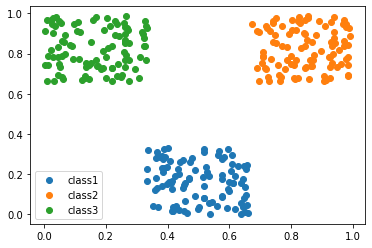

In [2]:
N = 100

class1 = torch.rand(2,N)/3
class1[0, :] = class1[0, :] + 0.33
class2 = torch.rand(2,N)/3 + 0.66
class3 = torch.rand(2,N)/3
class3[1, :] = class3[1, :] + 0.66
def draw_data(ax):
    ax.scatter(class1[0, :], class1[1, :], label="class1")
    ax.scatter(class2[0, :], class2[1, :], label="class2")
    ax.scatter(class3[0, :], class2[1, :], label="class3")
draw_data(plt)

dataset = torch.transpose(torch.cat((class1, class2, class3), dim=1), 0, 1)
labels = torch.cat((torch.zeros(N), torch.ones(N), torch.ones(N)*2)).type(torch.LongTensor)
plt.legend()
print(dataset.shape)

In [3]:
net = nn.Linear(2,3, bias=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.7)
pbar = tqdm.tqdm(range(100))
for i in pbar:
    for _ in range(100):
        optimizer.zero_grad()
        outputs = net(dataset)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"loss={loss.item():.3f}")

loss=0.003: 100%|██████████| 100/100 [00:01<00:00, 52.31it/s]


In [4]:
print("Weights:")
display(net.weight)
print("Bias:")
display(net.bias)

def weigth_f(x, y, vertex):
    b = 0
    if net.bias is not None:
        b = net.bias[vertex]
    return torch.dot(torch.tensor([x,y]),net.weight[vertex, :]).item() + b

Weights:


Parameter containing:
tensor([[  0.9690, -13.6137],
        [ 11.4009,   5.0580],
        [-12.4861,   7.6805]], requires_grad=True)

Bias:


Parameter containing:
tensor([ 7.4722, -8.5128,  1.3659], requires_grad=True)

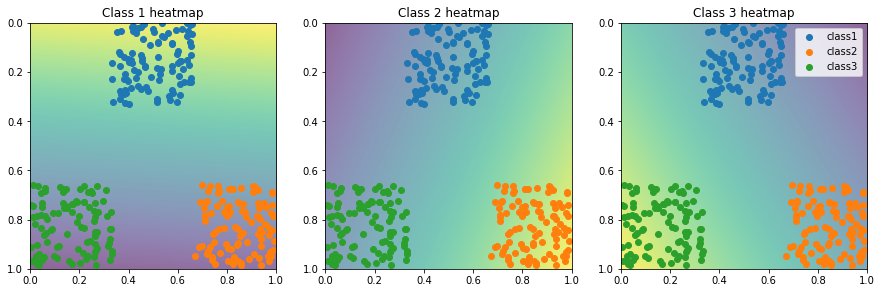

In [5]:
samples = 100
x = torch.linspace(0,1, samples)
y = torch.linspace(0,1, samples)
img = np.zeros((samples, samples))
fix, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    for y_i, y_val in enumerate(y):
        for x_i, x_val in enumerate(x):
            img[x_i][y_i] = weigth_f(y_val, x_val, i)
    axs[i].imshow(img, extent=(0,1,1,0), alpha=0.6)
    draw_data(axs[i])
    axs[i].set_title(f"Class {i+1} heatmap")
plt.legend()
plt.show()

In [6]:
class MassClustering(nn.Module):
    def __init__(
            self,
            n_dim,
            n_clusters,
            init_radius = 0.4,
            init_pos_offset = 0.2,
            init_pos_var = 0.4
        ):
        super().__init__()
        self.out_features = n_clusters
        self.in_features = n_dim
        c = torch.mul(torch.rand((n_clusters, n_dim)), init_pos_var)
        c = torch.add(c, torch.full((n_clusters, n_dim), init_pos_offset))
        self.g_constant = nn.Parameter(torch.ones(1))
        self.centroids = nn.Parameter(c)
        # this shall be the radius of each cluster
        s = torch.mul(torch.ones((n_clusters,)), init_radius)
        self.cluster_mass = nn.Parameter(s)
        self.max_dist = math.sqrt(self.in_features)

    def forward(self, input):
        self.centroids.data = torch.clamp(self.centroids, 0, 1)
        num_centroids = self.centroids.shape[0]
        input_repeated = input.repeat((1, num_centroids)).view(-1, num_centroids, self.in_features)
        input_distances = self.centroids - input_repeated
        input_distances = torch.norm(input_distances, p=2, dim=-1)
        input_distances = torch.div(input_distances, self.max_dist)
        cluster_forces = (self.g_constant * self.cluster_mass) / torch.square(input_distances)
        return cluster_forces

In [7]:
net = MassClustering(2,3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
pbar = tqdm.tqdm(range(100))
for i in pbar:
    for _ in range(100):
        optimizer.zero_grad()
        outputs = net(dataset)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"loss={loss.item():.3f}")

loss=0.000: 100%|██████████| 100/100 [00:04<00:00, 21.69it/s]


G constant


Parameter containing:
tensor([1.0323], requires_grad=True)

Centroids:


Parameter containing:
tensor([[0.5362, 0.2435],
        [0.7462, 0.7533],
        [0.2241, 0.8198]], requires_grad=True)

Masses:


Parameter containing:
tensor([0.4018, 0.4931, 0.3783], requires_grad=True)

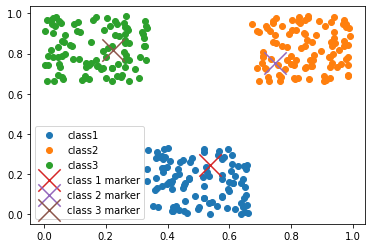

In [8]:
print("G constant")
display(net.g_constant)
print("Centroids:")
display(net.centroids)
print("Masses:")
display(net.cluster_mass)
draw_data(plt)
centroids = net.centroids.detach().numpy()
masses = net.cluster_mass.detach().numpy()
g_constant = net.g_constant.detach().item()
for i in range(centroids.shape[-2]):
    plt.scatter([centroids[i, 0]], [centroids[i, 1]], marker='x', s=500, label=f"class {i+1} marker")
plt.legend()

stats: max=1.0 min=0.5797111332802871
stats: max=1.0 min=0.574889852123349
stats: max=1.0 min=0.5509070235244012


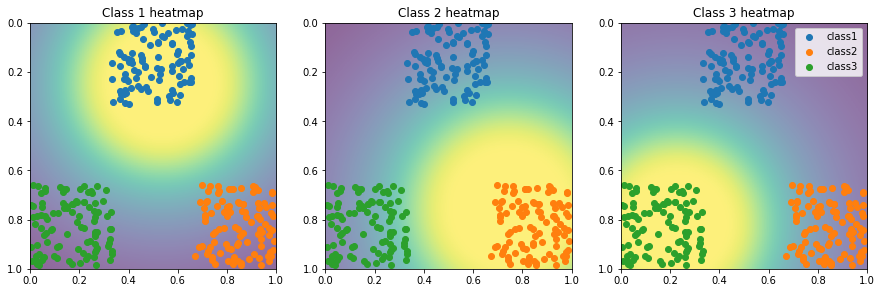

In [9]:
samples = 100
x = torch.linspace(0,1, samples)
y = torch.linspace(0,1, samples)
img = np.zeros((samples, samples))
fix, axs = plt.subplots(1, 3, figsize=(15,15))
def weigth_f(x, y, i):
    dist = np.linalg.norm(centroids[i] - np.array([x, y]), ord=2, axis=-1)/np.sqrt(2)
    f = (g_constant * masses[i]) / np.power(dist, 2)
    return f
for i in range(3):
    for y_i, y_val in enumerate(y):
        for x_i, x_val in enumerate(x):
            img[x_i][y_i] = weigth_f(y_val, x_val, i)
    img = img / 3
    img = 1/(1 + np.exp(-img)) # normalize with sigmoid for better display
    print(f"stats: max={np.max(img)} min={np.min(img)}")
    axs[i].imshow(img, extent=(0,1,1,0), alpha=0.6)
    draw_data(axs[i])
    axs[i].set_title(f"Class {i+1} heatmap")
plt.legend()
plt.show()

In [10]:
def generate_class_sampes(n_per_class):
    mu, sigma = 0, 0.01
    raw = np.random.normal(mu, sigma, (2, n_per_class))
    raw[0, :] += np.random.random()*0.9
    raw[1, :] += np.random.random()*0.9
    return torch.tensor(raw)
def prepare_dataset(data, n_per_class):
    dataset = torch.cat(data, 1)
    items_total = dataset.shape[-1]
    ohe = torch.cat([torch.ones(n_per_class) * i for i in range(int(items_total / n_per_class))])
    return (torch.transpose(dataset, 0, 1).float(), ohe.long())

torch.Size([1000])
torch.Size([1000, 2])


<Figure size 432x288 with 0 Axes>

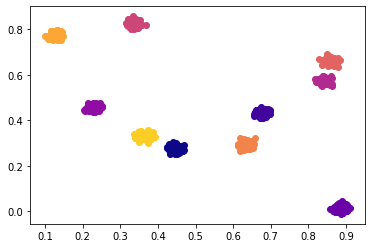

<Figure size 432x288 with 0 Axes>

In [11]:
N = 10
n_per_class = 100
data = []
for i in range(N):
    a = generate_class_sampes(n_per_class)
    data.append(a)
    plt.scatter(a[0, :], a[1, :], label=f"class{i}", color=cmap(i/N))
dataset, ohe = prepare_dataset(data, n_per_class)
print(ohe.shape)
print(dataset.shape)
plt.figure()

In [32]:
net = MassClustering(2,N)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
pbar = tqdm.tqdm(range(50))
for i in pbar:
    for _ in range(100):
        optimizer.zero_grad()
        outputs = net(dataset)
        loss = criterion(outputs, ohe)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"loss={loss.item():.3f}")

loss=0.000: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


(10, 2)


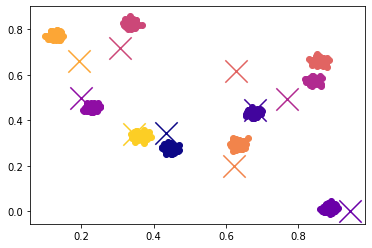

In [33]:
centroids = net.centroids.detach().numpy()
masses = net.cluster_mass.detach().numpy()
g_constant = net.g_constant.detach().item()
for i in range(N):
    plt.scatter(data[i][0, :], data[i][1, :], label=f"class{i}", color=cmap(i/N))
for i in range(centroids.shape[-2]):
    plt.scatter([centroids[i, 0]], [centroids[i, 1]], marker='x', s=500, label=f"class {i+1} marker", color=cmap(i/N))
# plt.legend()
print(centroids.shape)

stats: min=0.560350637224415 max=1.0
stats: min=0.5258175413495834 max=1.0
stats: min=0.5069951459546623 max=1.0
stats: min=0.5586849579720405 max=1.0
stats: min=0.5659837235203452 max=1.0
stats: min=0.5440777070926729 max=1.0
stats: min=0.6708939791382033 max=1.0
stats: min=0.5505279425896986 max=1.0
stats: min=0.5548868305460667 max=1.0


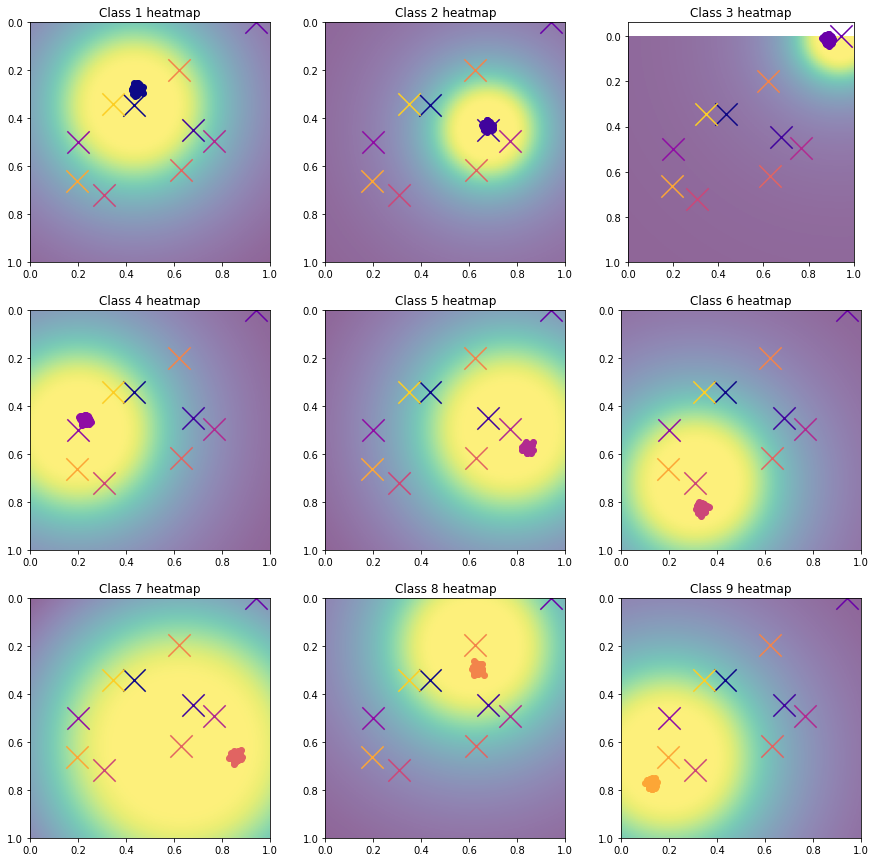

In [34]:
samples = 100
x = torch.linspace(0,1, samples)
y = torch.linspace(0,1, samples)
img = np.zeros((samples, samples))
fix, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.reshape((-1))
def weigth_f(x, y, i):
    dist = np.linalg.norm(centroids[i] - np.array([x, y]), ord=2, axis=-1)/np.sqrt(2)
    f = (g_constant * masses[i]) / np.power(dist, 2)
    return f
for i in range(N-1):
    for y_i, y_val in enumerate(y):
        for x_i, x_val in enumerate(x):
            img[x_i][y_i] = weigth_f(y_val, x_val, i)
    img = np.clip(img / 2, -709, 709)
    img = 1/(1 + np.exp(-img)) # normalize with sigmoid for better display
    print(f"stats: min={np.min(img)} max={np.max(img)}")
    axs[i].imshow(img, extent=(0,1,1,0), alpha=0.6)
    axs[i].scatter(data[i][0, :], data[i][1, :], label=f"class{i}", color=cmap(i/N))
    axs[i].set_title(f"Class {i+1} heatmap")
    for j in range(centroids.shape[-2]):
        axs[i].scatter([centroids[j, 0]], [centroids[j, 1]], marker='x', s=500, label=f"class {j+1} marker", color=cmap(j/N))
# plt.legend()
plt.show()

In [35]:
net = nn.Linear(2, N, bias=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
pbar = tqdm.tqdm(range(100))
for i in pbar:
    for _ in range(1000):
        optimizer.zero_grad()
        outputs = net(dataset)
        loss = criterion(outputs, ohe)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"loss={loss.item():.3f}")

loss=0.310: 100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


Weights:


Parameter containing:
tensor([[ -4.9581, -26.3057],
        [  7.3979,   3.5075],
        [ 23.3561, -31.2137],
        [-28.0356,   2.2677],
        [ 26.2801,   4.3546],
        [ -3.4416,  25.0605],
        [ 15.3961,  29.1697],
        [ 12.5503, -19.4396],
        [-33.4078,  20.7652],
        [-13.7704,  -9.6333]], requires_grad=True)

Bias:


Parameter containing:
tensor([ 15.2934,  -1.2844,  -2.4559,  13.3977, -15.9568,  -7.6855, -21.9093,
          3.7957,   2.8506,  13.7780], requires_grad=True)

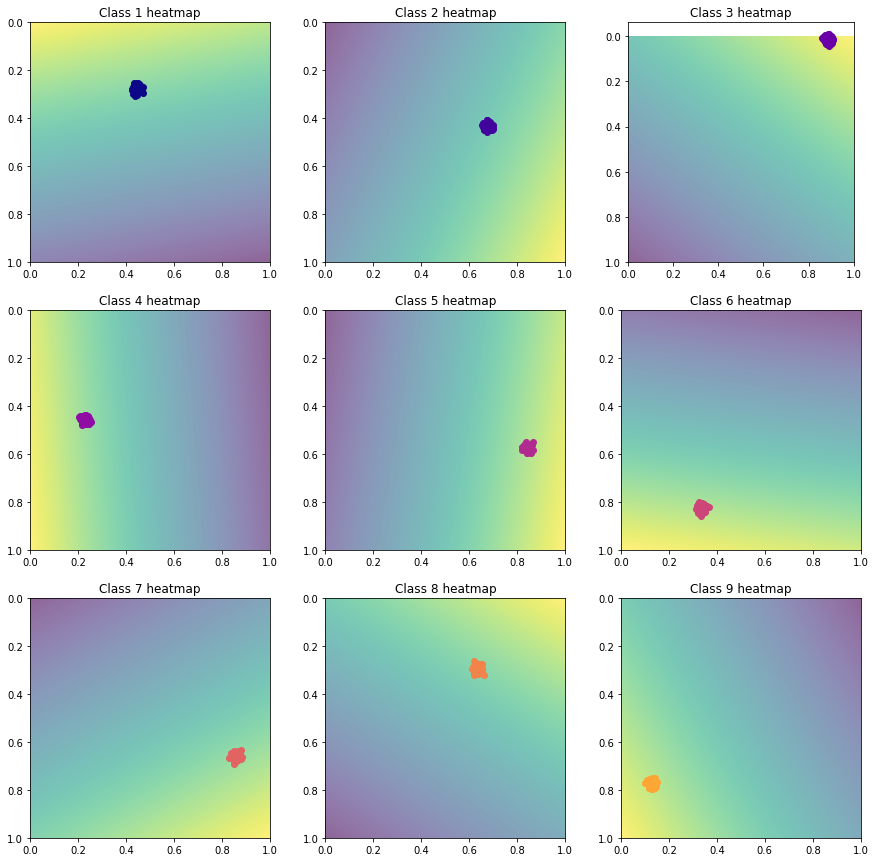

In [36]:
print("Weights:")
display(net.weight)
print("Bias:")
display(net.bias)

def weigth_f(x, y, vertex):
    b = 0
    if net.bias is not None:
        b = net.bias[vertex]
    return torch.dot(torch.tensor([x,y]),net.weight[vertex, :]).item() + b

samples = 100
x = torch.linspace(0,1, samples)
y = torch.linspace(0,1, samples)
img = np.zeros((samples, samples))
fix, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.reshape((-1))
for i in range(N-1):
    for y_i, y_val in enumerate(y):
        for x_i, x_val in enumerate(x):
            img[x_i][y_i] = weigth_f(y_val, x_val, i)
    axs[i].imshow(img, extent=(0,1,1,0), alpha=0.6)
    axs[i].scatter(data[i][0, :], data[i][1, :], label=f"class{i}", color=cmap(i/N))
    axs[i].set_title(f"Class {i+1} heatmap")
# plt.legend()
plt.show()